In [19]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\User\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


# Import Libraries

In [20]:
import json
import os.path
import pandas as pd
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
from PIL import Image

# 1.Processing  metadata file with image metadata

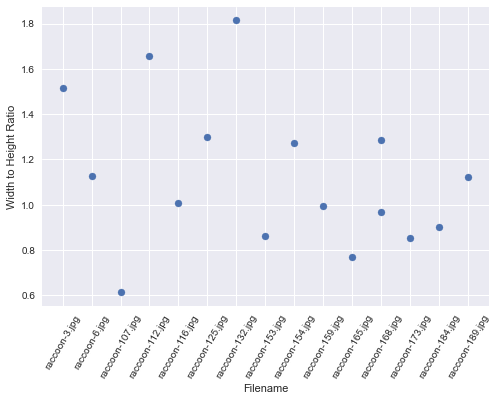

In [53]:
label_type = 'Raccoon'
file_prefix = "input_images_source_"
path_to_output = './data_output.json'
files = os.listdir('.')
list_of_json = []
list_of_dicts =[]
list_of_filenames = []
list_width_to_height_ratio = []


#Checks if output file exists and if it does deletes it
if os.path.isfile(path_to_output):
    os.remove(path_to_output)
else:
    pass


#Creates a list with  the content of all  image metadata JSON files
for file in files:
    if file_prefix in file:
        jpath = './'+ file
        data_file = os.listdir(jpath)
        for item in data_file:
            if item.endswith('.json'):
                json_file = open(jpath + "/" + item)
                data = json.load(json_file)
                list_of_json.append(data)

#Loops through all Json files in the list and calculates the labels's width to height ration and label area percentage.
# Also extracts the rest of the data for the Output JSON
for item in list_of_json:
    for image in item['data']:
        if 'filename' in image.keys() and image['filename'].endswith('jpg') == False:
            image['filename'] = image['filename'] + '.jpg'
        if 'path' not in image.keys():
            path_to_image = image['folder'] +image['filename']
            filename = image['filename']
        else:
            path_to_image = image['path']
            filename = path_to_image.split('/')[-1]
        im_data = Image.open(path_to_image)
        if filename.endswith('.jpg') == False:
            pth_lst = path_to_image.split(".")
            pth_lst[-1] = '.jpg'
            pth = "".join(pth_lst)
            path_to_image = pth
            im_data.save(pth)
            filename = filename.replace(filename.split('.')[-1],'jpg')
        image_width, image_height = im_data.size
        image_area = image_width * image_height
        if 'label_width' not in image.keys() and 'label_height' not in image.keys():
            if  image['xmax'] > 1:
                image['xmax'] = image['xmax'] / image_width
                image['xmin'] =image['xmin'] / image_width
                image['ymax'] =image['ymax'] / image_height
                image['ymin'] =image['ymin'] / image_height
                xmax,xmin,ymax,ymin = image['xmax'],image['xmin'],image['ymax'],image['ymin']
            else:
                xmax, xmin, ymax, ymin = image['xmax'], image['xmin'], image['ymax'], image['ymin']
            label_width = (xmax - xmin) * image_width
            label_height = (ymax - ymin) * image_height
        else:
            label_width = image['label_width']
            label_height =image ['label_height']
        label_area = label_height * label_width
        width_to_height =round(label_width / label_height,3)
        label_area_perc = round(label_area / image_area,1)
        if 'xmax' in image.keys():
            xmax, xmin, ymax, ymin = image['xmax'], image['xmin'], image['ymax'], image['ymin']
        else:
            xmax = (image['label_horz_center'] + (label_width/2))/image_width
            xmin = (image['label_horz_center'] - (label_width / 2))/image_width
            ymax = (image['label_vert_center'] + (label_height / 2))/image_height
            ymin = (image['label_vert_center']  - (label_height / 2))/image_height
        list_of_filenames.append(filename)
        list_width_to_height_ratio.append(width_to_height)
        dictionary = {
 "path": path_to_image,
 "filename": filename,
 "image_height": image_height,
 "image_width": image_width,
 "label_area_perc": label_area_perc,
 "labels": [
 {
 "xmin": round(xmin,1),
 "ymin": round(ymin,1),
 "xmax": round(xmax,2),
 "ymax": round(ymax,2),
 "label": label_type,
 "width_to_height": width_to_height
 }]}
        list_of_dicts.append(dictionary)
plt.xticks(rotation =60)
plt.xlabel('Filename')
plt.ylabel('Width to Height Ratio')
plt.style.use('seaborn')
plt.scatter(list_of_filenames,list_width_to_height_ratio)

output = {'data': list_of_dicts}
output_json = json.dumps(output,indent=4)

with open ('data_output.json','w') as outfile:
    outfile.write(output_json)



# 2.  Processes images

In [55]:
config = open('./config.json')
config = json.load(config)

img_data = open ('./data_output.json')
img_data = json.load(img_data)



In [59]:
for image in img_data['data']:
    img_labels = image['labels'][0]
    img = cv2.imread(image['path'])
    img = cv2.resize(img,(config['max_width'],config['max_height']))
    cv2.rectangle(img,(int(img_labels['xmin']*config['max_width']),int(img_labels['ymin']*config['max_height'])),(int(img_labels['xmax']*config['max_width']),int(img_labels['ymax']*config['max_height'])),(0,0,255),5)
    cv2.putText(img,label_type,((int(img_labels['xmin']*config['max_width']) +30),int(img_labels['ymin']*config['max_height'])+30),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
    img = img[int(img_labels['ymin']*config['max_height']):int(img_labels['ymax']*config['max_height']),int(img_labels['xmin']*config['max_width']):int(img_labels['xmax']*config['max_width'])]
    cv2.imshow(image['filename'],img)
    cv2.waitKey(0)
    
    #cv2.rectangle(img,(int(img_labels['xmin']*config['max_width']),int(img_labels['ymin']*config['max_height'])),(int(img_labels['xmax']*config['max_width']),int(img_labels['ymax']*config['max_height'])),(0,0,255),5)